# Vessel segmentation in retina fundus images

In this assignment, we are going to develop a system to automatically **segment vessels** in human retina fundus images. For this purpose, we are going to use data from the publicly available DRIVE dataset (http://www.isi.uu.nl/Research/Databases/DRIVE/).
The DRIVE dataset consists of 40 images, 20 used for training and 20 used for testing. Each case contains:
* fundus (RGB) image
* a binary mask, which indicates the area of the image that has to be analyzed (removing black background)
* manual annotations of retina vessels, provided as a binary map

## Clinical background

Retinal vessel segmentation and delineation of morphological attributes of retinal blood vessels, such as length, width, tortuosity, branching patterns and angles are utilized for the diagnosis, screening, treatment, and evaluation of various cardiovascular and ophthalmologic diseases such as diabetes, hypertension, arteriosclerosis and chorodial neovascularization.

Automatic detection and analysis of the vasculature can assist in the implementation of screening programs for diabetic retinopathy, can aid research on the relationship between vessel tortuosity and hypertensive retinopathy, vessel diameter measurement in relation with diagnosis of hypertension, and computer-assisted laser surgery.

Automatic generation of retinal maps and extraction of branch points have been used for temporal or multimodal image registration, retinal image mosaic synthesis. Moreover, the retinal vascular tree is found to be unique for each individual and can be used for biometric identification.





## Tasks for this assignment

1. Develop a system to segment vessels in retina image in this notebook. You will have to submit this notebook with your code, which we will run and evaluate, together with the results of the segmentation.
2. Use the training set provided with the DRIVE dataset to train/tune the parameters of your system. You cannot use data from the test set available on the DRIVE website, nor from other datasets. 
3. Apply it to the test dataset and generate a binary map of the segmented vessels. The map must have the same size as the input image.
4. Submit the results of the notebook to the mini-challenge framework by running the corresponding cell in this notebook (at the end of the notebook). This will automatically submit your results to the mini-challenge framework. You will be able to visualize your scores in the **CHALLENGE** section of the webpage (http://ismi17.diagnijmegen.nl/). Note that after you submit the notebook, we will run your implementation and reproduce your result in order to evaluate your assignment. Any significant discrepancy between the results submitted to the mini-challenge framework and the one computed using this notebook will be penalized and discussed with the student.

## Implementation 

#### Mandatory task
You will be asked to implement your vessel segmentation system based on **pixel classification based on texture analysis**.
For this purpose, you can use the following publications as reference:

* [1] M. Niemeijer et al. "Comparative study of retinal vessel segmentation methods on a new publicly available database"
* [2] Y. Yang et al., "An automatic hybrid method for retinal blood vessel extraction"
* [3] M.M. Fraz et al., "Blood vessel segmentation methodologies in retinal images - A survey"

The first paper explains how to segment retinal vessels using pixel classification.
In this assignment, you should implement the solution based on pixel classification as is explained in the first paper. As done in [1], the classifier used in this assignment is **k-Nearest Neighbors** (kNN).
This part of the assignment is **mandatory**.

#### Optional task
Next, you could try to **improve the segmentation** result. The goal is to design the best CAD system for vessel segmentation and validate its performance on the DRIVE dataset! A few ideas to improve the system are:

* More features (Local Binary Patterns, Gabor filters, use rotated derivative of Gaussian filters, etc.). Get creative!
* Postprocessing to improve the results using morphological filtering
* More training samples
* etc.

This second part is **optional** and will be evaluated to give some extra points to your grade.

In the rest of this notebook, we will provide you with convenience functions and snippets of code that you can use to implement your solution.

## Data
Download the data that will be used in this assignment from this link: https://surfdrive.surf.nl/files/index.php/s/VZnaAZ8GWTZCCka (password: ismi2017)
In the rest of the notebook, we assume that you have saved the folder in a 'data' subfolder in the same directory where the notebook is running. If not, please modify the paths in the cells.

In [1]:
# import libraries needed for this assignment
import os
import numpy as np
from math import floor
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 12)
from sklearn.neighbors import KNeighborsClassifier
import scipy.signal
from challenger import submit_results

In [2]:
# function to get a list of file of a given extension, both the absolute path and the filename
def get_file_list(path,ext='',queue=''):
    if ext != '':
        return [os.path.join(path,f) for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')],  [f for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')]    
    else:
        return [os.path.join(path,f) for f in os.listdir(path)]

Point to the local copy of training data

In [3]:
tra_img_dir = './data/DRIVE/training/images'
tra_msk_dir = './data/DRIVE/training/mask'
tra_lbl_dir = './data/DRIVE/training/1st_manual'

tra_imgs = sorted(get_file_list(tra_img_dir, 'tif')[0])
tra_msks = sorted(get_file_list(tra_msk_dir, 'gif')[0])
tra_lbls = sorted(get_file_list(tra_lbl_dir, 'gif')[0])

Define a function to visualize (1) the fundus image, (2) the binary mask, (3) the manual annotation of a case with a given index.

In [4]:
def show_image(idx, imgs, msks, lbls):
    img = np.asarray(Image.open(imgs[idx]))
    msk = np.asarray(Image.open(msks[idx]))
    lbl = np.asarray(Image.open(lbls[idx]))
    img_g = img[:,:,1].squeeze().astype(float)
    plt.subplot(1,3,1)
    plt.imshow(img); plt.title('RGB image {}'.format(idx+1))
    plt.subplot(1,3,2)
    plt.imshow(msk, cmap='gray'); plt.title('Mask {}'.format(idx+1))
    plt.subplot(1,3,3)
    plt.imshow(lbl, cmap='gray'); plt.title('Manual annotation {}'.format(idx+1))
    plt.show()

Show the training set using the function defined

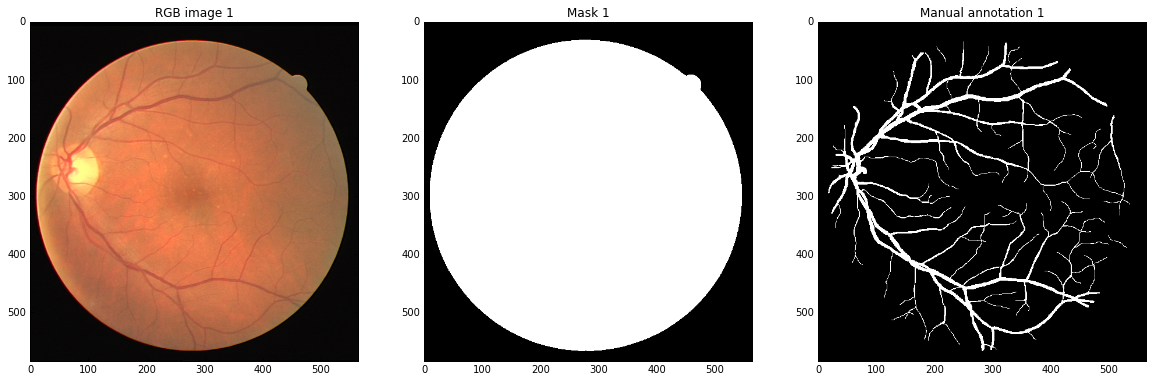

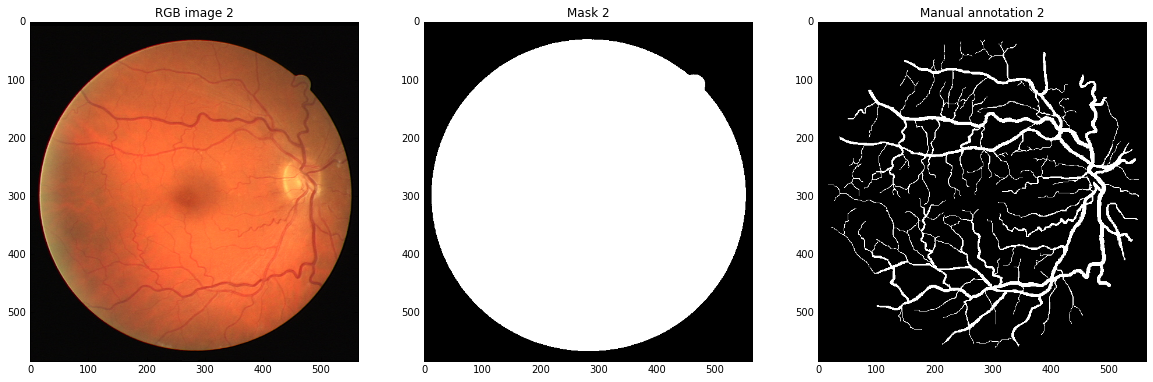

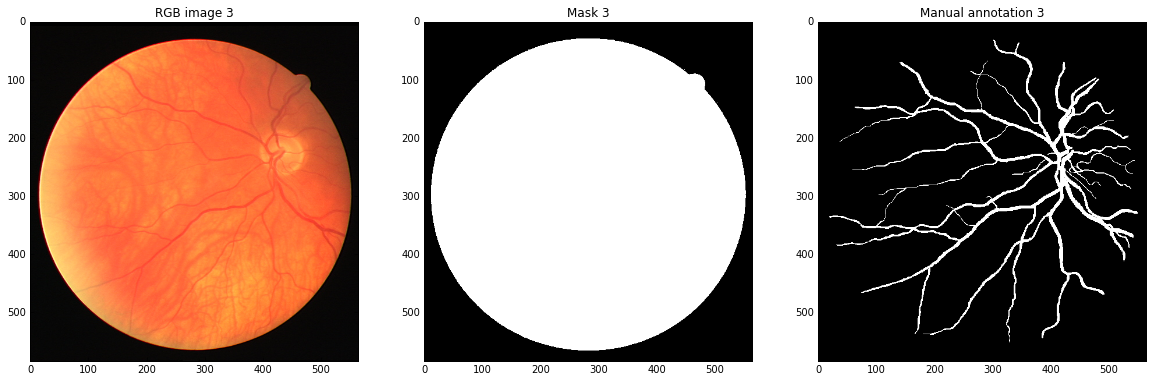

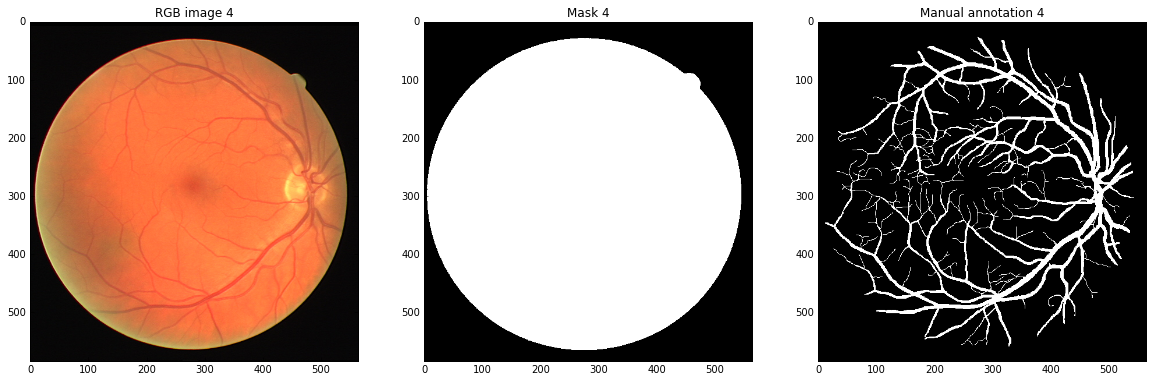

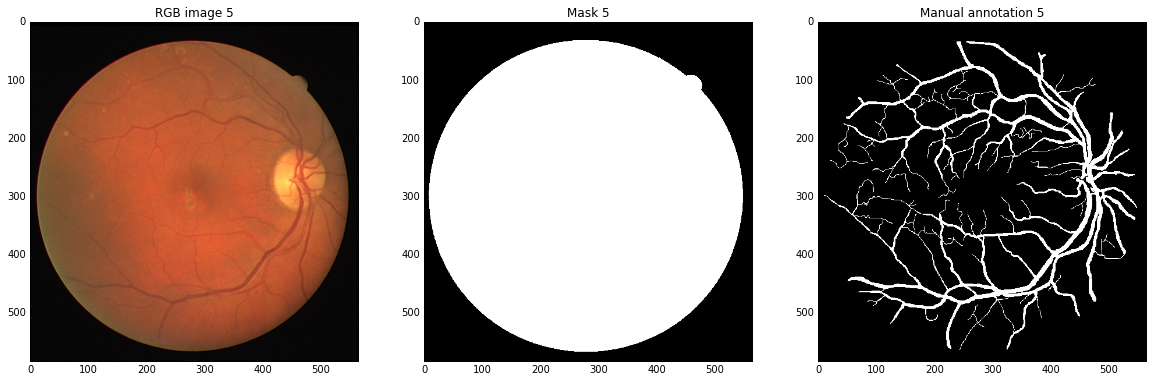

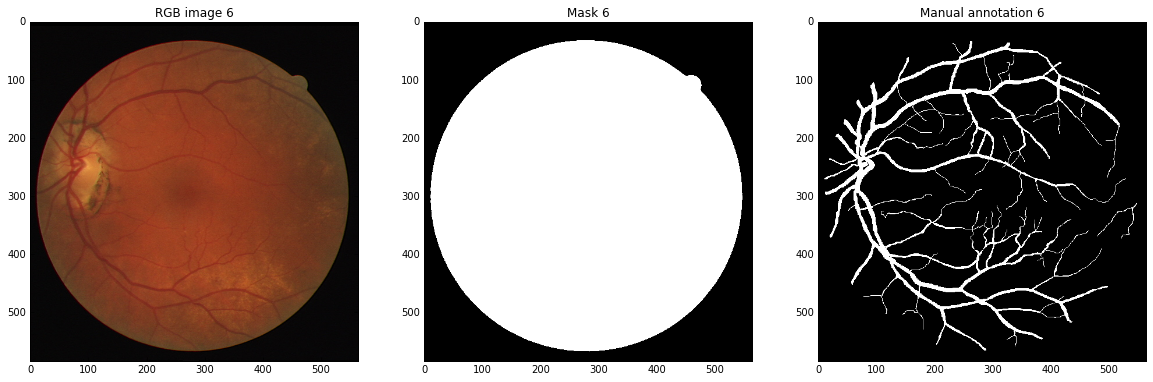

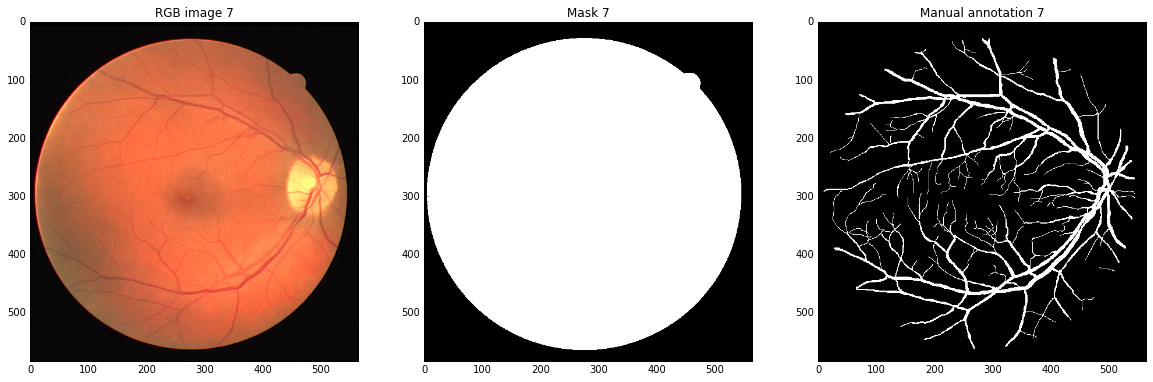

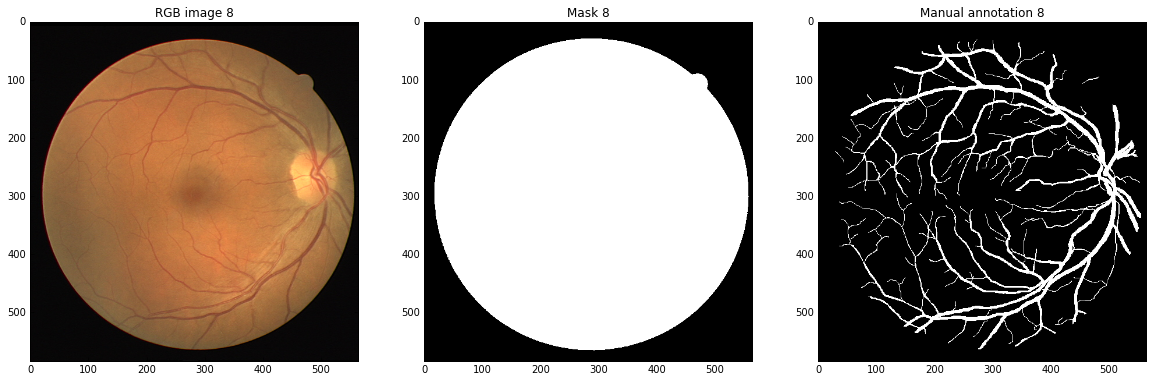

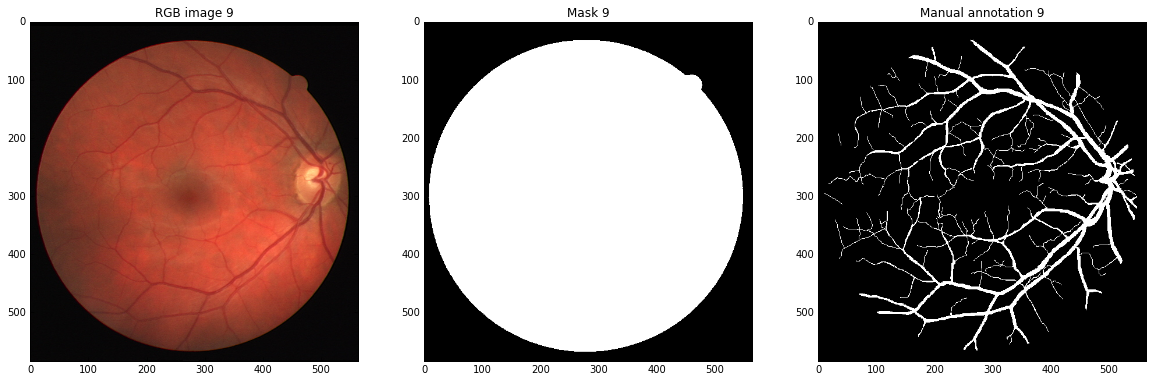

KeyboardInterrupt: 

In [5]:
for i in range(len(tra_imgs)):
    show_image(i, tra_imgs, tra_msks, tra_lbls)

## 1: Pixel classification and texture analysis

Here we will provide the structure of a CAD system to do pixel classification based on texture analysis. Note that we will only provide the structure and few basic functions implemented, while you will have to implement the rest.
We will also ask questions, which you will have to answer.

### Collecting labeled samples (training)

A method based on texture analysis and pixel classification, requires a set of labeled samples, for which the correct label is known. We call this a *training set*. In order to build a training set, positive (vessel) and negative (non-vessel) samples have to be extracted from the images in the training set. This set will be used to compare new (test) samples with reference data, using for example a <b>nearest-neighbour</b> strategy for assigning labels.

We have read images, masks and manual annotations from the training set already:
* tra_imgs
* tra_msks
* tra_lbls

### Create a Gaussian filter kernel

The system described in [1] uses filters based on Gaussian and derivative of Gaussian functions. Now we will create a two-dimensional Gaussian filter kernel that can be used the extract features from an image. 
The part of code that you will implement to create the Gaussian kernel is in the next cell, followed by a piece of code to visualize the Gaussian kernel.

**Note**. If you completed the first assignment, you have implemented this function already. You can reuse the one you defined in the first assignment.

In [6]:
def gauss_filter(sigma_mm, x0=0.0, y0=0.0):
    x_vec = np.arange(-sigma*3, sigma*3, 1.0) 
    y_vec = np.arange(-sigma*3, sigma*3, 1.0)
    xx,yy = np.meshgrid(x_vec,y_vec)
    kernel = (1/(2*np.pi*sigma_mm**2)) * np.exp(-(xx**2+yy**2)/(2*sigma_mm**2))
    return kernel


def get_gaus_deriv(g):
    gx  = np.gradient(g,axis=0)
    gxx = np.gradient(g,axis=0)
    gxy = np.gradient(g,axis=1)
    
    gy  = np.gradient(g,axis=1)
    gyy = np.gradient(g,axis=1)
    gyx = np.gradient(g,axis=0)
    return gx, gy, gxx, gyy, gxy, gyx

The following code will help you create the Gaussian filter kernel by visualizing it in 3D. 

In [9]:
# code to test and visualize the gaussian kernel
def visualize_gaussian_kernel(sigma):
    """ 
        Visualizes the Gaussian kernel defined above for a given sigma.
    """    
    gaussian_kernel = gauss_filter(sigma) #calculate the Gaussian filter kernel

    fig = plt.figure()
    ax = Axes3D(fig)
    x_dim, y_dim = gaussian_kernel.shape
    x,y = np.meshgrid(range(x_dim), range(y_dim))
    offset_x = floor(x_dim/2)
    offset_y = floor(y_dim/2)

    x = x - float(offset_x)
    y = y - float(offset_y)  
    #ax.plot_surface(x, y, gaussian_kernel, antialiased=True, cmap=cm.jet, linewidth=0)
    ax.plot_surface(x, y, gaussian_kernel, rstride=1, cstride=1, cmap=cm.jet)

Show the Gaussian filter kernel you defined in the function above, Try changing sigma to see the kernel at different scales.

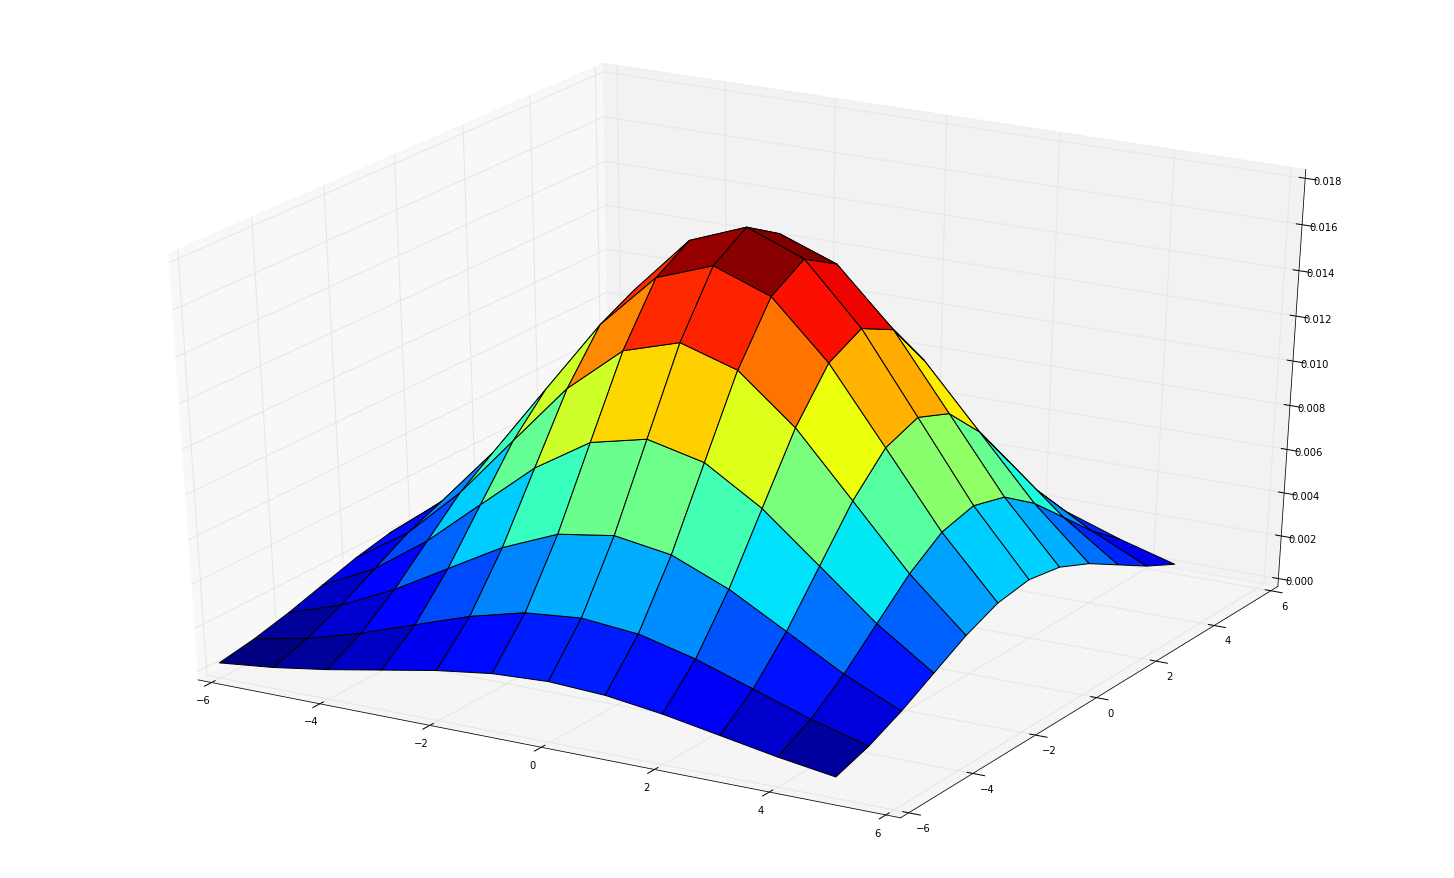

In [10]:
# example of visualization
sigma = 2
visualize_gaussian_kernel(3)

### Create the feature extractor
The next function you will implement is a feature_extractor that will extract features from an image. Extracting a feature from an image will result in a feature map with the same size as the input image, but different pixel values. You will have to decide what filters, or texture analysis operators will be used to describe the appearance of pixels. The input for feature extraction used in [1] is the **green channel** of the fundus image. 

Suggested features (also used in [1]): 
- Gaussian filter response at different scales
- Derivatives of Gaussians at different scales
- Second derivatives at different scales
    
In order to define the number of features, consider the approach that you are going to implement. If based on paper [1], several filters based on a Gaussian kernel will be used, at several scales. Define the list of sigma values that you are going to use and derive the number of features that you will need. Consider that one of the channels of the RGB image can also be considered as a feature (image intensity).    
    
Suggested functions to use
 - np.gradient
 - scipy.signal.fftconvolve

In [39]:
def extract_features(img, sigmas, n_features=1):
    """
        Computes features from a given input image with given sigmas.
        Output of this function is a 3 dimensional numpy array containing
        the different computed features for the given input image.
    """    
    dims = img.shape # dimensions of the image
    
    features = np.zeros((dims[0], dims[1], n_features)) # each feature map has the same size as the input image
    
    # the first feature we use is the pixel intensity in the green channel itself
    img_g = img[:,:,1] #I just assume it follows the RGB convention and not GBR or BGR...
    features[:,:,0] = img_g
    
    # >>> YOUR CODE STARTS HERE <<<
    i = 1
    for s in sigmas:
        g = gauss_filter(s)
        gx, gy, gxx, gyy, gxy, gyx = get_gaus_deriv(g)
        features[:,:,i] = scipy.signal.fftconvolve(img_g, g, mode='same') ;i+=1
        features[:,:,i] = scipy.signal.fftconvolve(img_g, gx, mode='same') ;i+=1
        features[:,:,i] = scipy.signal.fftconvolve(img_g, gy, mode='same') ;i+=1
        features[:,:,i] = scipy.signal.fftconvolve(img_g, gxx, mode='same') ;i+=1
        features[:,:,i] = scipy.signal.fftconvolve(img_g, gyy, mode='same') ;i+=1
        features[:,:,i] = scipy.signal.fftconvolve(img_g, gxy, mode='same') ;i+=1
    # >>> YOUR CODE ENDS HERE <<<  
        
    return features

### Parameters
Now, we initialize the numpy arrays that will contain training samples (x) and corresponding training labels (y). The matrix x_train will contain the features of each pixel in the training set, one sample per row, and one feature per column. The vector y_train will contain the corresponding label of each training sample. This is the data format that most of the classification libraries require (the library suggested in this notebook is sklearn [http://scikit-learn.org/]).

In [40]:
# set the parameters for your CAD system here
n_samples_per_class_per_image = 1000 # how many positive/negative pixels per image in the training set?
n_classes = 2           # how many classes in this problem?
sigmas = [1,2,4,8,16]   # what values of sigma?
n_features = 31         # how many features?

# define training data and labels
x_train = np.zeros((n_classes * n_samples_per_class_per_image * len(tra_imgs), n_features))  
y_train = np.zeros((n_classes * n_samples_per_class_per_image * len(tra_imgs), 1))

#### Question
How did you define the value(s) of sigma? In mm or in px? Can you get the pixel size from this kind of images?

We just have pixels, but don't know the dpi. We can only estimate that an eye is around 3 cm wide, so we have 

The following function is useful when you want to collect samples randomly selected from a given binary mask, for example when you want to obtain positive and negative samples from a segmentation map. In the case of vessel segmentation, this function can be used to obtain a given number of coordinates that contain pixels labeled as vessel or non-vessel.

In [41]:
def get_random_indexes(msk, n_idxs):
    """ 
        Returns rows and columns of user-defined positive and negative indexes.
        The variable msk is a binary map in numpy format.
    """
    pos_idxs = np.array(np.where(msk > 0))
    neg_idxs = np.array(np.where(msk == 0))
    n_pos = pos_idxs.shape[1] # number of positives found in the mask
    n_neg = neg_idxs.shape[1] # number of negatives found in the mask
    n_min = min(n_neg, min(n_idxs, n_pos))
    rnd_idxs_pos = range(n_pos)
    np.random.shuffle(rnd_idxs_pos)
    rnd_idxs_neg = range(n_neg)
    np.random.shuffle(rnd_idxs_neg)
    return pos_idxs[:, rnd_idxs_pos[:n_min]], neg_idxs[:, rnd_idxs_neg[:n_min]] 

The following piece of code will loop through the images in the training set and extract features using the feature extractor you implemented. Next, it will pick random locations (using the function above) in the image for background pixels and foreground pixels. 
Using these locations and the produced features you can now fill the numpy arrays 'train_x' and 'train_y' with a set of training samples (x) and corresponding training labels (y) to be used for training.

In [42]:
tmp_array = np.empty((0,n_features))
y = np.empty(0)
for f in range(len(tra_imgs)):
     
    # load training image and annotation
    img = np.asarray(Image.open(tra_imgs[f]))
    lbl = np.asarray(Image.open(tra_lbls[f]))
                
    # extract features from the given images
    print('extracting features for image ' + str(f+1))
    features = extract_features(img, sigmas, n_features) # implement the extract_features function defined above!

    # extract random position of samples     
    p_idx, n_idx = get_random_indexes(lbl, n_samples_per_class_per_image)    
    
    ## TODO
    pos_feat = features[p_idx[0,:],p_idx[1,:],:]
    neg_feat = features[n_idx[0,:],n_idx[1,:],:]
    pos_lbl = lbl[p_idx[0,:],p_idx[1,:]]
    neg_lbl = lbl[n_idx[0,:],n_idx[1,:]]
    
    tmp_array = np.append(tmp_array, pos_feat, axis=0)
    tmp_array = np.append(tmp_array, neg_feat, axis=0) # we append the array
    y = np.append(y, pos_lbl)
    y = np.append(y, neg_lbl)
x_train[:,:] = tmp_array[:,:] # I copy the array to check for  right dimensions
y_train[:,0] = y[:]   
ranges = np.ptp(x_train,axis=0)

extracting features for image 1
extracting features for image 2
extracting features for image 3
extracting features for image 4
extracting features for image 5
extracting features for image 6
extracting features for image 7
extracting features for image 8
extracting features for image 9
extracting features for image 10
extracting features for image 11
extracting features for image 12
extracting features for image 13
extracting features for image 14
extracting features for image 15
extracting features for image 16
extracting features for image 17
extracting features for image 18
extracting features for image 19
extracting features for image 20


#### Question
What is the range of values that you obtained for each feature? Are all features in the same range of values?

Ranges are saved in the 'ranges' variable. The are quite different for different features

### Normalization
When several descriptors are used to extract features, the values obtained are typically in different range of values. This may be a problem for classifiers like k-Nearest Neighbor, since features with very larg values contribute more than others in the distance measure, which will result in wrong classification.

When kNN is used, and in general when any classifier is used, it is good to normalize the range of values **per feature**. As a result, we would like each feature to have a range of values comparable to the others.
A commonly used strategy to normalize training data is to transform it to have **zero mean** and **unit variance**.

Implement a normalization function that will make sure the training dataset has zero mean and unit variance in the cell below.
The function should also return the mean and standard deviation of your training dataset.

In [28]:
def normalization(x_train):
    """
        Normalization of x_train
    """ 
    # >>> YOUR CODE STARTS HERE <<<
    
    meanV = np.mean(x_train, axis = 0) # vector of mean values
    stdV = np.std(x_train, axis = 0)  # vector of standard deviation values
    x_train_norm = (x_train-meanV)/stdV
     
    # >>> YOUR CODE ENDS HERE <<<
    
    return x_train_norm, meanV, stdV

x_train_norm, meanV, stdV = normalization(x_train)

For convenience, you can save your training data, which you can load later and use for testing purposes without the need to rebuild it every time you run an experiment. You may want to define a flag to enable/disable training, or just execute some cells in this notebook instead of executing all cells. You may want to add more varables that you think will be necessary to test new samples.

In [29]:
# save training data to disk in numpy format
np.savez('./data/training_data.npz', x_train=x_train, y_train=y_train, 
         x_train_norm=x_train_norm, meanV=meanV, stdV=stdV)

### Train the classifier
Now that you have created the (normalized) training data we can use it to train our classifier! Since you will use a kNN classifier, you will have to set an optimal value for the only parameter that it requires, **K**.

In [31]:
# load training data, define a nearest-neighbour classifier and train it.
K = 30 # define the K parameter
npz = np.load('./data/training_data.npz')    
neigh = KNeighborsClassifier(n_neighbors=K) 
neigh.fit(npz['x_train_norm'], npz['y_train'].ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

#### Question
The kNN classifier that you used require the input parameter k (n_neighbours). What is the optimal k for your problem? How did you find it?

The paper suggests 30, so why not use that?

### Test the classifier
Now that we have stored our training set and defined a classification model, we can apply it to some unseen data and evaluate its performance.

First we load the test data:

In [32]:
# test images
tes_img_dir = './data/DRIVE/test/images'
tes_msk_dir = './data/DRIVE/test/mask'

tes_imgs = sorted(get_file_list(tes_img_dir, 'tif')[0])
tes_msks = sorted(get_file_list(tes_msk_dir, 'gif')[0])

result_output_folder = './data/DRIVE/test/results'
if not(os.path.exists(result_output_folder)):
    os.mkdirs(result_output_folder)

#### Question

Do you think that you have to apply some kind of normalization to test data as well? In case you do, what do you think is the best strategy? Will you compute statistics (mean, std) on the test set, or will you use the ones from the training set? Why?

We need to standardize it so that the values follow the same distribution as the train set. Else our distances are off.

In [44]:
# define vectors of mean value and standard deviation for the test set here
mean_test = meanV
std_test = stdV

In [45]:
def normalization_test(x_test, meanV, stdV):
    """
        Normalization of the test data
    """ 
    eps = np.finfo(float).eps    
    x_test_post = (x_test - meanV)/(stdV + eps) 
    
    return x_test_post

In the next cell we loop over all the images in the test set and do the following for every image:

* Extract features for every pixel in the image
* Apply normalization
* Classify every pixel
* Save the output to disk
    
In the classification step, the output of the classifier can be:
* the predicted label of the test sample classified
* a likelihood value (pseudo-probability), based on processing distance measures

In order to optimize the performance of our system, we would like to obtain some kind of probability for each pixel, which we can later post-process by applying a threshold, which we will have to optimize. By changing the threshold, the amount of pixel classified as vessel and as background will change.

In [46]:
probability_threshold = 0.5 # Optimize this parameter

# classify all images in the test set
for f in range(len(tes_imgs)):
    
    # load test image and mask
    img = np.asarray(Image.open(tes_imgs[f]))
    msk = np.asarray(Image.open(tes_msks[f]))
            
    ns = img.shape[0] * img.shape[1] #number of samples is ALL pixels in the image
    x_test = np.zeros((ns, n_features))
    
    # compute features
    print ('extraction features for image ' + str(f+1))
    features = extract_features(img, sigmas, 31)    
    for k in range(features.shape[2]):
        x_test[:,k] = features[:,:,k].flatten()
    
    # normalize
    x_test_norm = normalization_test(x_test, mean_test, std_test)

    print('labeling pixels with nearest-neighbor...')
    p_test = neigh.predict_proba(x_test_norm)
    
    p_test_reshaped = p_test[:,0].reshape(img.shape[0], img.shape[1]) * msk
    final_output = (p_test_reshaped > optimal_threshold) * 255 # Threshold the probabilitymap to obtain the final result
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(p_test_reshaped)
    plt.subplot(1,3,3)
    plt.imshow(final_output)
    plt.show()
    
    im = Image.fromarray(final_output.astype('uint8'))
    im.save(os.path.join(result_output_folder, str(f+1) + "_mask.png"))
    

extraction features for image 1
labeling pixels with nearest-neighbor...


NameError: name 'optimal_threshold' is not defined

### Submit your result

After processing all the images in the test set you can upload your result to the challenge website and see how well you performed compared to your collegues! You can submit as often as you want, only the best result counts.

Enter your username and password in the cell below to submit your result. You can add a description for your own reference. This description will be also shown in the website, which you can use as a reference to keep track of your the development of your system.

You should have received your username and password by email. Otherwise, TAs will give you a temporary spare account.

In [ ]:
user = {'username': 'S.Kern', 'password' : '5CCN6PW2'} # enter you username and password
description = {'notes' : 'testing result submission system'}

submit_results (user, os.path.abspath(result_output_folder), description)

**Check your result!** http://ismi17.diagnijmegen.nl/

## 2. Improve your results! [optional]

Try to improve your results and resubmit.

A few ideas to improve the system are:

* Design a segmentation system based on morphology, without using pixel classification.
* Improve the performance of your existing system by:
  * Using more features (Local Binary Patterns, Gabor filters, use rotated derivative of Gaussian filters, etc.). Get creative!
  * Postprocessing to improve the results using morphological filtering
  * Using more training samples
  * etc.

